# This notebook demonstrates the usage of `synthesis_general()` on a GPU
You'll be generating random data, random new non-uniform location, and calculate the synthesized SHT map at this location.
Note that the calls are slightly different for the two backends.

In [22]:
from IPython.display import clear_output
import numpy as np
import cupy as cp
import healpy as hp
from scipy.special import comb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cunusht
from cunusht.utils import good_lmax_array, Alm, synalm, alm2cl

def camb_clfile(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.

    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.

    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    if len(cols) > 5:
        wpp = lambda ell : ell ** 2 * (ell + 1) ** 2 / (2. * np.pi)
        wptpe = lambda ell : np.sqrt(ell.astype(float) ** 3 * (ell + 1.) ** 3) / (2. * np.pi)
        for i, k in enumerate(['pp', 'pt', 'pe']):
            cls[k] = np.zeros(lmax + 1, dtype=float)
        cls['pp'][ell[idc]] = cols[5][idc] / wpp(ell[idc])
        cls['pt'][ell[idc]] = cols[6][idc] / wptpe(ell[idc])
        cls['pe'][ell[idc]] = cols[7][idc] / wptpe(ell[idc])
    return cls

def add_colorbar_to_axis(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
def get_coef(lmax=1023):
    def smoothstep(x, x_min=0, x_max=1, N=1):
        x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
        result = 0
        for n in range(0, N + 1):
            result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
        result *= x ** (N + 1)
        return result

    ll = np.arange(0,lmax+1)
    cl = (1+np.sin(ll/3)**2)*smoothstep(ll, lmax//50)
    return synalm(cl, lmax=lmax, mmax=lmax), cl

def locs(tGPU, lmax):
    loc = tGPU.get_grid_uniform()
    pointing_theta = (loc[0,:].reshape(lmax+1,-1)+0.05*cp.sin(2*np.pi/3*cp.linspace(0,np.pi,lmax+1)).reshape(-1,1)**2*cp.sin(2*2*np.pi*cp.linspace(0,np.pi,lmax+1).reshape(-1,1))).flatten()
    pointing_phi = loc[1,:]
    pointing_theta = cp.where(pointing_theta>np.pi,pointing_theta-np.pi, pointing_theta)
    pointing_theta = cp.where(pointing_theta<0,pointing_theta+np.pi, pointing_theta)
    pointing_phi = cp.where(pointing_phi>2*np.pi,pointing_phi-2*np.pi, pointing_phi)
    pointing_phi = cp.where(pointing_phi<0,pointing_phi+2*np.pi, pointing_phi)
    loc = cp.array([pointing_theta, pointing_phi])

    loc_nod = tGPU.get_grid_uniform()
    return loc, loc_nod

# GPU

Details about previous cell can be ignored, it's merely helper functions and generating some toy data. The following cell is the heart of cunusht

In [23]:
lmax, mmax = good_lmax_array[25],  good_lmax_array[25]
geominfo = ('gl',{'lmax': lmax})
kwargs = {
    'geominfo_deflection': geominfo,
    'nuFFTtype': 2,
    'epsilon': 1e-7,
}
tGPU = cunusht.get_transformer(backend='GPU')(**kwargs)

coef, cl = get_coef(lmax)
loc, loc_nod = locs(tGPU, lmax)

res = tGPU.nusht2d2(lmax=lmax, mmax=mmax, alm=cp.array(coef), loc=cp.array(loc.T), epsilon=kwargs['epsilon'], pointmap=cp.empty(shape=tGPU.npix()), verbose=True)

clear_output()

And here is the result, three plots showing the effect of the deflection

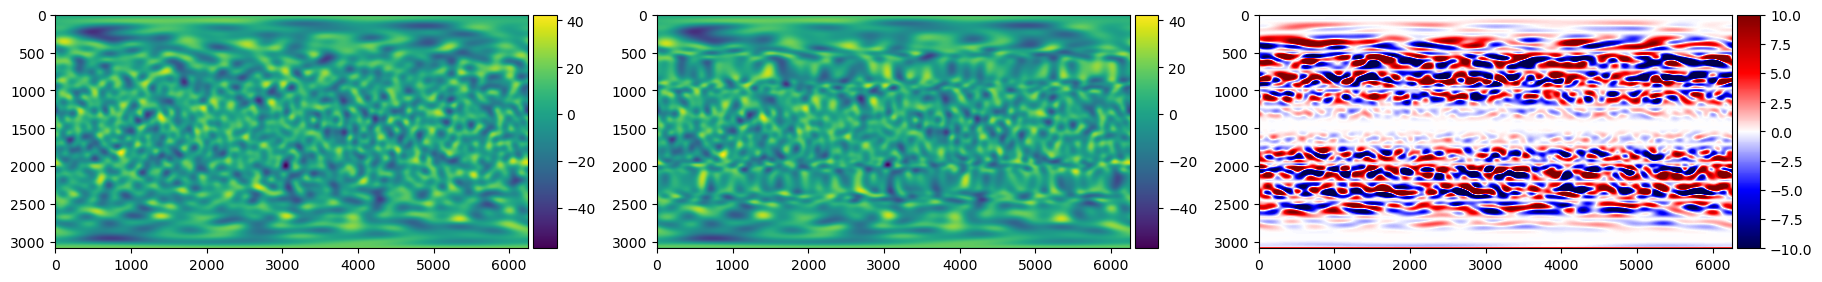

In [25]:
m = cp.empty(tGPU.npix())
m = tGPU.synthesis(cp.array(coef), out=m, lmax=lmax, mmax=lmax)
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon = kwargs['epsilon']*1e8
im = ax[2].imshow(m.get().reshape(-1,lmax+1).T-res.get().reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon, cmap='seismic')
add_colorbar_to_axis(fig, ax[2], im)

In [28]:
coef = cp.array(coef)
locT = cp.array(loc.T)
p = cp.empty(shape=tGPU.npix())
%timeit tGPU.nusht2d2(lmax=lmax, mmax=mmax, alm=coef, loc=locT, epsilon=kwargs['epsilon'], pointmap=p, verbose=False)

40.9 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## What did we do?

`geominfo` is the geometry onto which the final map is calculated. We choose a 'Gauss-Legendre' geometry due to it obeying a sampling theorem.
We also demonstrate nuFFT-planning by providing 'nuFFTtype' and 'epsilon', so that we can calculate `nusht2d2()` without having to repeatedly initialise it.

You needed SHT coefficients `coef` at a uniform-grid, and the non-uniform `pointing` grid at which the map is evaluated.

We created random coefs, but supressed small scales to give it some structure

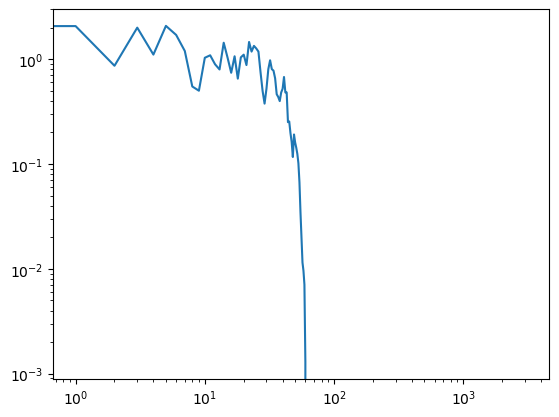

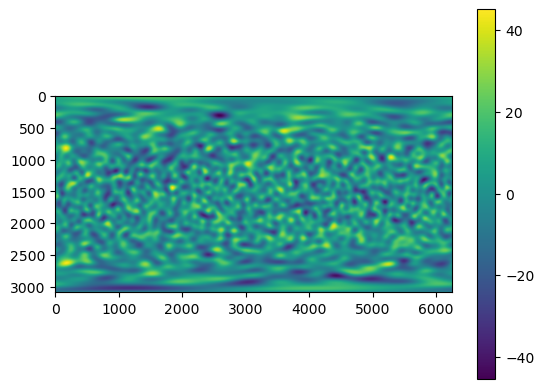

In [5]:
plt.plot(hp.alm2cl(coef.get()))
plt.loglog()
plt.show()

plt.imshow(m.get().reshape(-1,lmax+1).T)
plt.colorbar()

For the pointing we choose something simple, like a `sin()` function that shifts all theta locations away from the uniform grid by a small amount. We also provide a reference pointing `loc_nod` that does exactly no remapping.

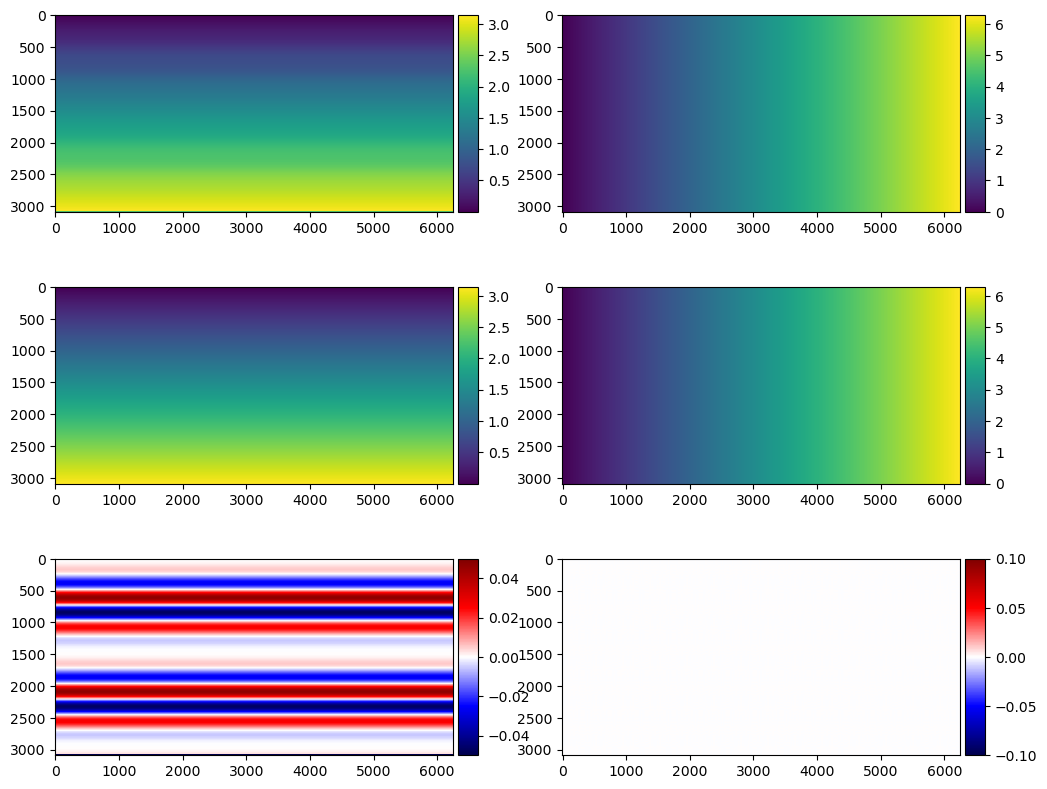

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

im = ax[0,0].imshow(loc[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,0], im)

im = ax[0,1].imshow(loc[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,1], im)

im = ax[1,0].imshow(loc_nod[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,0], im)

im = ax[1,1].imshow(loc_nod[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,1], im)

im = ax[2,0].imshow((loc[0,:]-loc_nod[0,:]).get().reshape(lmax+1,-1), vmin=-0.05,vmax=0.05, cmap='seismic')
add_colorbar_to_axis(fig, ax[2,0], im)

im = ax[2,1].imshow((loc[1,:]-loc_nod[1,:]).get().reshape(lmax+1,-1), cmap='seismic')
add_colorbar_to_axis(fig, ax[2,1], im)

### We can use this transformer to repeatedly call `synthesis_general()`, which is not only conventient, but also fast. No more initialisation needed, you can even change the `loc` in each call, if wanted.

In [7]:
for n in range(5):
    coef_, _ = get_coef(lmax)
    res = tGPU.nusht2d2(lmax=lmax, mmax=mmax, alm=cp.array(coef_), loc=cp.array(loc.T), epsilon=kwargs['epsilon'], pointmap=cp.empty(shape=tGPU.npix()), verbose=True)
    # res = tGPU.nusht2d2(lmax=lmax, mmax=mmax, alm=cp.array(coef), loc=cp.array(loc.T), epsilon=kwargs['epsilon'], pointmap=cp.empty(shape=tGPU.npix()), verbose=True)
    print(res)

[17.74646818 17.74669061 17.746913   ... 17.85258285 17.8535094
 17.85443568]
[2.94960337 2.94973245 2.94986157 ... 2.81259884 2.8131483  2.8136978 ]
[ 1.23153158  1.23168374  1.23183634 ... -0.26139974 -0.26072768
 -0.26005381]
[-4.70767933 -4.70758335 -4.70748752 ... -4.16137294 -4.16103518
 -4.16069823]
[-1.51828607 -1.51815506 -1.51802415 ... -1.17276586 -1.17219913
 -1.17163271]


## gclm2lenmap()
This is a convenience function in case you have a deflection field, which is likely the case if you are a CMB lensing analyst. The following cell uses a deflection field that is zero, therefore you won't see any deflection. Feel free to create your own toy deflection field

In [ ]:
lmax = good_lmax_array[25]
cls = camb_clfile("/mnt/home/sbelkner/git/delensalot/delensalot/data/cls/FFP10_wdipole_lenspotentialCls.dat")
print(f"lmax is {lmax}")
clsig, cldef = cls['tt'][:lmax+1], cls['pp'][:lmax+1]

toydeflm = synalm(cldef, lmax=lmax, mmax=lmax)

res = tGPU.gclm2lenmap(cp.array(coef), dlm_scaled=cp.zeros(shape=coef.shape), lmax=lmax, mmax=lmax, lenmap=cp.empty(shape=tGPU.npix()))

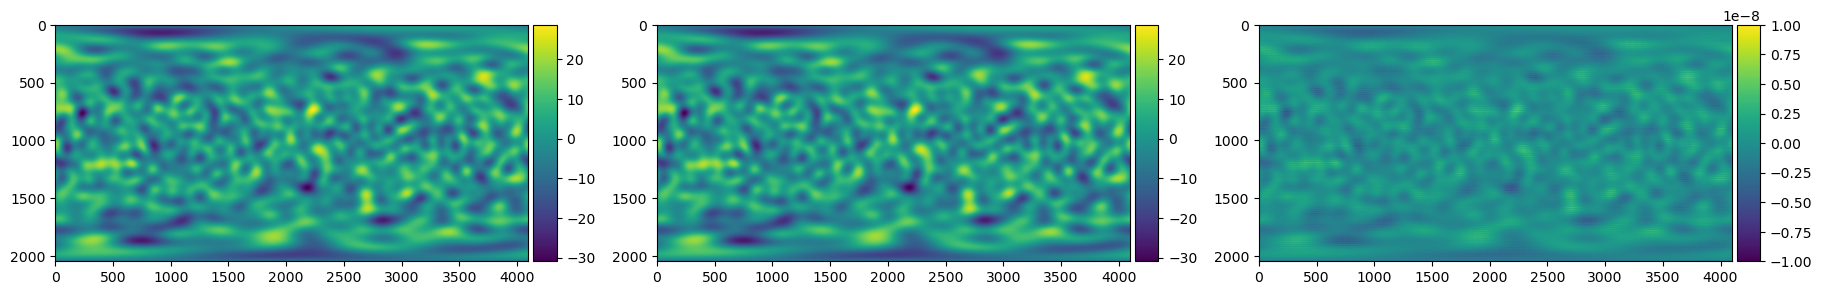

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon = kwargs['epsilon']*1e-1
im = ax[2].imshow(m.get().reshape(-1,lmax+1).T-res.get().reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon)
add_colorbar_to_axis(fig, ax[2], im)

# CPU
In case you'd like to run these functions on the CPU, the following cells show how that would work.

The following cell creates a transformer with the CPU as backend

In [29]:
lmax, mmax = good_lmax_array[25], good_lmax_array[25]
geominfo = ('gl',{'lmax':lmax})
kwargs = {
    'geominfo_deflection':  geominfo,
    'epsilon': 1e-7,
}

tCPU = cunusht.get_transformer(backend='CPU')(**kwargs)
dglm = np.empty(Alm.getsize(lmax, mmax))*0.
tCPU.setup_lensing(dglm, mmax_dlm=mmax, nthreads=10, verbose=False, epsilon=kwargs['epsilon'], single_prec=False)

clear_output()

## Let's get the result

In [30]:
pointmap = np.empty(tCPU.deflectionlib.geom.npix())
res = tCPU.synthesis_general(lmax=lmax, mmax=lmax, alm=np.array(np.atleast_2d(coef.get())), spin=0, mode="STANDARD", loc=np.array(loc.get()).T, epsilon=kwargs['epsilon'], nthreads=10, verbose=0)

note: the difference map is only expected to be at the order of epsilon, if there is no deflection, i.e. if you use `loc_nod`

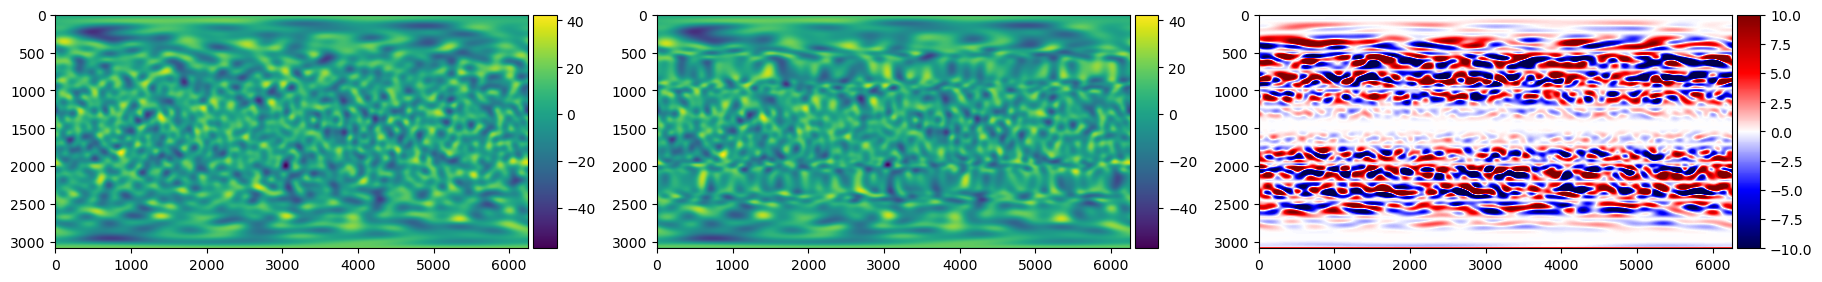

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

im = ax[1].imshow(res.reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1], im)

epsilon = kwargs['epsilon']*1e8
im = ax[2].imshow(m.get().reshape(-1,lmax+1).T-res.reshape(lmax+1,-1), vmin=-epsilon, vmax=epsilon, cmap='seismic')
add_colorbar_to_axis(fig, ax[2], im)

In [32]:
alm = np.array(np.atleast_2d(coef.get()))
locT = np.array(loc.get()).T
%timeit tCPU.synthesis_general(lmax=lmax, mmax=lmax, alm=alm, spin=0, mode="STANDARD", loc=locT, epsilon=kwargs['epsilon'], nthreads=10, verbose=0)

300 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
